**ABSTRACTIVE TEXT SUMMARIZATION USING NLP**

**PROJECT GROUP: SHRI DATTA MADHIRA, RAHUL REDDY BADDAM, SRI CHARAN VEMURI**

**HOW TO RUN**
  1. Run all the cells from PACKAGES to PREDICTION one by one. 
  2. Go to the FUNCTIONS section of the ipynb. You will find two subsections,
  each for one model. 
  3. Run model_execute cells in both subsections to train the model.
  4. Run the model_predict cell in both subsections to predict summaries.

# PACKAGES

In [1]:
import numpy as np
import pandas as pd 
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [2]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# READ CSV

In [4]:
def get_data(path, num_rows=100000):
  fr_data = pd.read_csv("Reviews.csv",nrows=num_rows)
  fr_data.rename(columns={'Text': 'text', 'Summary': 'summary'}, 
                inplace=True)

  fr_data.drop_duplicates(subset=['text'], inplace=True)
  fr_data.dropna(axis=0, inplace=True)

  # fr_data.head(2)

  return fr_data

# TEXT PREPROCESSING

https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [6]:
stop_words = set(stopwords.words('english')) 

def preprocess_text(text,flag):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if not flag:
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1: #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [7]:
def clean_df(df):
  cleaned_text = []
  for t in df['text']:
    cleaned_text.append(preprocess_text(t, 0))

  cleaned_summary = []
  for t in df['summary']:
    cleaned_summary.append(preprocess_text(t, 1))

  print(cleaned_text[:2])
  print(cleaned_summary[:2])

  df['cleaned_text'] = cleaned_text
  df['cleaned_summary'] = cleaned_summary

  df.replace('', np.nan, inplace=True)
  df.dropna(axis=0, inplace=True)

  df.head(2)

  return df

# UNDERSTANDING THE DATA

In [8]:
import matplotlib.pyplot as plt

def data_plt(data):
  text_word_count = []
  summary_word_count = []

  # populate the lists with sentence lengths
  for i in data['cleaned_text']:
        text_word_count.append(len(i.split()))

  for i in data['cleaned_summary']:
        summary_word_count.append(len(i.split()))

  return pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
  

In [9]:
def summary_lengths(data, summ_len):
  count = 0
  for i in data:
      if(len(i.split()) <= summ_len):
          count += 1
  print("% of summaries with len <", summ_len, ":", count/len(data))

def text_lengths(data, txt_len):
  count = 0
  for i in data:
      if(len(i.split())<=txt_len):
          count += 1
  print("% of texts with len <", txt_len, ":", count/len(data))

In [10]:
def create_final_df(data, txt_len, summ_len):
  cleaned_text = np.array(data['cleaned_text'])
  cleaned_summary = np.array(data['cleaned_summary'])

  short_text=[]
  short_summary=[]

  for i in range(len(cleaned_text)):
      if(len(cleaned_summary[i].split())<=summ_len and len(cleaned_text[i].split())<=txt_len):
          short_text.append(cleaned_text[i])
          short_summary.append(cleaned_summary[i])
          
  df=pd.DataFrame({'text':short_text,'summary':short_summary})
  df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

  return df

# MODELS

## TRAIN TEST SPLIT

In [11]:
from sklearn.model_selection import train_test_split

def split_df(df):
  return train_test_split(np.array(df['text']),np.array(df['summary']),
                          test_size=0.1,random_state=0,shuffle=True) 


## Preparing the Tokenizers



In [12]:
def rare_word_coverage(tknzr, threshold):
  # Rare words and their coverage.
  threshold=threshold
  count = 0
  tot_cnt=0
  freq=0
  tot_freq=0

  for key,value in tknzr.word_counts.items():
      tot_cnt=tot_cnt+1
      tot_freq=tot_freq+value
      if(value<threshold):
          count += 1
          freq += value  
  print("\t% of rare words in vocabulary:",(count/tot_cnt)*100)
  print("\tTotal Coverage of rare words:",(freq/tot_freq)*100)

  return tot_cnt, count


def x_tokenizer_run(x_train, x_validate, max_txt_len):
  #prepare a tokenizer for 'text' on training data
  x_tokenizer = Tokenizer() 
  x_tokenizer.fit_on_texts(list(x_train))

  total_count, count = rare_word_coverage(x_tokenizer, 4)

  #prepare a tokenizer for reviews on training data
  x_tokenizer = Tokenizer(num_words=total_count-count) 
  x_tokenizer.fit_on_texts(list(x_train))

  #convert text sequences into integer sequences
  x_tr_seq    =   x_tokenizer.texts_to_sequences(x_train) 
  x_val_seq   =   x_tokenizer.texts_to_sequences(x_validate)

  #padding zero upto maximum length
  x_train    =   pad_sequences(x_tr_seq,  maxlen=max_txt_len, padding='post')
  x_validate   =   pad_sequences(x_val_seq, maxlen=max_txt_len, padding='post')

  #size of vocabulary ( +1 for padding token)
  return x_tokenizer.num_words + 1, x_tokenizer, x_train, x_validate
  

def y_tokenizer_run(y_train, y_validate, max_summ_len):
  #prepare a tokenizer for 'summary' on training data
  y_tokenizer = Tokenizer()   
  y_tokenizer.fit_on_texts(list(y_train))

  total_count, count = rare_word_coverage(y_tokenizer, 6)

  #prepare a tokenizer for reviews on training data
  y_tokenizer = Tokenizer(num_words=total_count-count) 
  y_tokenizer.fit_on_texts(list(y_train))

  #convert text sequences into integer sequences
  y_tr_seq    =   y_tokenizer.texts_to_sequences(y_train) 
  y_val_seq   =   y_tokenizer.texts_to_sequences(y_validate) 

  #padding zero upto maximum length
  y_train    =   pad_sequences(y_tr_seq, maxlen=max_summ_len, padding='post')
  y_validate   =   pad_sequences(y_val_seq, maxlen=max_summ_len, padding='post')

  # Let us check whether word count of start token is equal to length of the training data
  print(y_tokenizer.word_counts['sostok'],len(y_train))

  #size of vocabulary
  return  y_tokenizer.num_words +1, y_tokenizer, y_train, y_validate


## FINAL CLEAN UP

In [13]:
# deleting the rows that contain only START and END tokens - TRAIN

def delete_no_info_rows(x, y):
  idx=[]
  for i in range(len(y)):
      count = 0
      for j in y[i]:
          if j!=0:
              count += 1
      if(count == 2):
          idx.append(i)

  y = np.delete(y, idx, axis=0)
  x = np.delete(x, idx, axis=0)

  return x, y

## MODEL BUILDING

https://medium.com/@iit2018056/text-summarization-with-attention-based-networks-8492e9277c0

Return Sequences = True: LSTM produces the hidden state and cell state for every timestep

Return State = True: LSTM produces the hidden state and cell state of the last timestep only

Stacked LSTM: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence.

In [15]:
from keras import backend as K 
from attention import AttentionLayer
# from tensorflow.python.framework.ops import disable_eager_execution

# disable_eager_execution()
K.clear_session()

def create_model(attention_flag):
  global encoder_inputs, decoder_inputs, decoder_outputs, state_h, state_c, dec_emb_layer, encoder_outputs, decoder_lstm, decoder_dense, attn_layer

  # Encoder
  encoder_inputs = Input(shape=(max_text_len,))

  #embedding layer
  enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

  #encoder lstm 1
  encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

  #encoder lstm 2
  encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
  encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
  # encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output1)

  #encoder lstm 3
  encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
  encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = Input(shape=(None,))

  #embedding layer
  dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
  decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

  if attention_flag:
    # Attention Layer
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
    # Concat attention input and decoder LSTM output
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
    #dense layer
    decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_concat_input)
  else:
    #dense layer
    decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)
  
  return Model([encoder_inputs, decoder_inputs], decoder_outputs) 


In [16]:
def build_model(attention_flag):
  return create_model(attention_flag) 
  

## COMPILE MODEL

In [17]:
def compile_model(model):
  model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

## FIT

In [18]:
def model_fit(model):
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
  return model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

## PLOT HISTORY

In [1]:
from matplotlib import pyplot

def history_plt(history):
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.xlabel("Epochs")
  pyplot.ylabel("Loss")
  pyplot.legend()
  pyplot.show()


# PREDICTIONS

In [20]:
def get_word_indexes(x_tokenizer, y_tokenizer):
  return y_tokenizer.index_word, x_tokenizer.index_word, y_tokenizer.word_index

def inference(attention_flag):
  # Encode the input sequence to get the feature vector
  encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

  # Decoder setup
  # Below tensors will hold the states of the previous time step
  decoder_state_input_h = Input(shape=(latent_dim,))
  decoder_state_input_c = Input(shape=(latent_dim,))
  decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

  # Get the embeddings of the decoder sequence
  dec_emb2= dec_emb_layer(decoder_inputs) 
  # To predict the next word in the sequence, set the initial states to the states from the previous time step
  decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

  if attention_flag:
    #attention inference
    attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])
    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_outputs2 = decoder_dense(decoder_inf_concat) 
  else:
    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_outputs2 = decoder_dense(decoder_outputs2) 

  # Final decoder model
  decoder_model = Model(
      [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
      [decoder_outputs2] + [state_h2, state_c2])
  
  return encoder_model, decoder_model

In [21]:
def decode_sequence(input_seq, encoder_model, decoder_model, target_word_index, reverse_target_word_index):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq, verbose=0)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [22]:
def seq2summary(input_seq, target_word_index, reverse_target_word_index):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq, reverse_source_word_index):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [30]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
ROUGE = Rouge()

def predict(n, x_tr, y_tr, encoder_model, decoder_model, target_word_index, reverse_target_word_index, reverse_source_word_index):
  bleu, rouge = 0, 0
  for i in range(0,n):
    og_text = seq2text(x_tr[i], reverse_source_word_index)
    og_summ = seq2summary(y_tr[i], target_word_index, reverse_target_word_index)
    pred_summ = decode_sequence(x_tr[i].reshape(1,max_text_len), encoder_model, decoder_model, target_word_index, reverse_target_word_index)
    bleu += sentence_bleu([og_summ],pred_summ)
    rouge += ROUGE.get_scores(hyps=pred_summ, refs=og_summ)[0]["rouge-1"]["f"]
    if (i % 50 == 0):
      print("Text:", og_text)
      print("Original summary:", og_summ)
      print("Predicted summary:", pred_summ)
      print("\n")
  return bleu, rouge

In [28]:
def model_predict(attention_flag, n):
  # Predict
  print("Predicting...")
  rev_tgt_wrd_idx, rev_src_wrd_idx, tgt_wrd_idx = get_word_indexes(x_tknzr, y_tknzr)
  enc_model, dec_model = inference(attention_flag)
  bleu_score, rouge_score = predict(n, x_tr, y_tr, enc_model, dec_model, tgt_wrd_idx, rev_tgt_wrd_idx, rev_src_wrd_idx)

  print("BLEU SCORE: %.4f | ROUGE SCORE: %.4f"%(bleu_score/n, rouge_score/n))

# FUNCTIONS

In [25]:
def model_execute(attention_flag):

  global latent_dim, embedding_dim, max_text_len, max_summary_len, x_voc, y_voc, x_tknzr, x_tr, x_val, y_tknzr, y_tr, y_val

  # Read CSV File
  print("Reading from file...")
  df = get_data("Reviews.csv", 150000)
  # print(list(df.columns.values))

  # Clean DataFrame
  print("Cleaning text in file...")
  df = clean_df(df)
  # print(list(df.columns.values))

  # Understanding the data
  print("Histogram - Food Reviews Dataset")
  fr_df = data_plt(df)
  fr_df.hist(bins=30)
  plt.show()

  print("FOOD REVIEWS DATASET: ")
  summary_lengths(df['cleaned_summary'], 8)
  text_lengths(df['cleaned_text'], 50)

  # Creating the final dataframe
  print("Creating final df...")
  max_text_len = 50
  max_summary_len = 8
  final_df = create_final_df(df, max_text_len, max_summary_len)
  # print(final_df.head(2))

  # Train Test Split
  print("Splitting data...")
  x_tr, x_val, y_tr, y_val = split_df(final_df)

  # Tokenizing the data
  print("Tokenizing data...")
  print("X Tokenizer: ")
  x_voc, x_tknzr, x_tr, x_val = x_tokenizer_run(x_tr, x_val, max_text_len)
  print("\tX_vocab = ", x_voc)

  print("y Tokenizer: ")
  y_voc, y_tknzr, y_tr, y_val = y_tokenizer_run(y_tr, y_val, max_summary_len)
  print("\ty_vocab = ", y_voc)

  # Final Clean-up
  print("Cleaning training and validation data...")
  x_tr, y_tr = delete_no_info_rows(x_tr, y_tr)
  x_val, y_val = delete_no_info_rows(x_val, y_val)

  # Set Model parameters
  print("Setting model parameters...")
  latent_dim = 300
  embedding_dim = 100

  # Model Building & Compiling
  print("Building and Compiling model... ")
  fr_model = build_model(attention_flag)
  print(fr_model.summary())
  compile_model(fr_model)

  # Model Fitting
  print("Fitting model...")
  history = model_fit(fr_model)
  history_plt(history)


### MODEL-1 (AttentionFlag: False)

Reading from file...
Cleaning text in file...
['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo']
['good quality dog food', 'not as advertised']
Histogram - Food Reviews Dataset


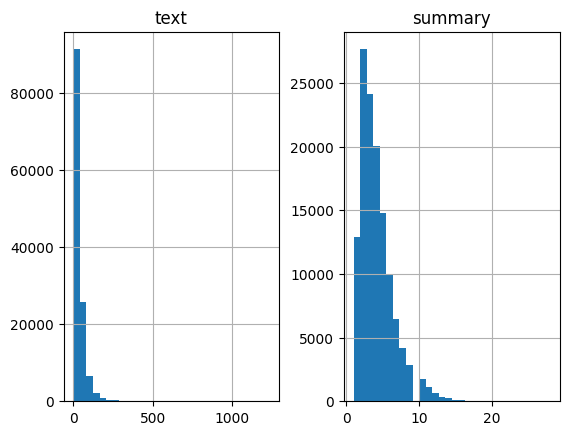

FOOD REVIEWS DATASET: 
% of summaries with len < 8 : 0.9428853941049063
% of texts with len < 50 : 0.7766895815676303
Creating final df...
Splitting data...
Tokenizing data...
X Tokenizer: 
	% of rare words in vocabulary: 65.69576132790601
	Total Coverage of rare words: 1.7851696951213896
	X_vocab =  14075
y Tokenizer: 
	% of rare words in vocabulary: 76.56593809593663
	Total Coverage of rare words: 3.778434287958601
85689 85689
	y_vocab =  3196
Cleaning training and validation data...
Setting model parameters...
Building and Compiling model... 


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 100)      1407500     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 300),    481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

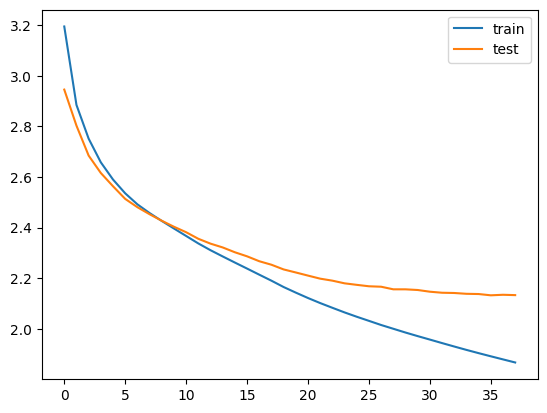

In [26]:
model_execute(False)

In [31]:
model_predict(False, len(y_val))

Predicting...
Text: cookies delicious period happen organic happen vegan kids cookies cook vegan food looking cookies banana pudding gotten around making pudding yet cookies almost gone thank goodness subscribe save 
Original summary: great tasting cookies not just for kids 
Predicted summary:  great cookies


Text: present grandmother loves tea pleased get glad bought sent 
Original summary: present 
Predicted summary:  great tea


Text: bought really impressed crunchy nutty good berry flavor ten year old even liked plus felt like snacking something halfway healthy going try vanilla flavor next 
Original summary: very tasty 
Predicted summary:  good snack


Text: looking cool gift someone special maybe special still need preserve reputation cutting edge trend setter take someone idea pasta well idea anything different find supermarket isle hey cooking shows tv top chef stuff smile complimented great taste gift giving 
Original summary: cool gift you look great giving it 
Predicted sum

### MODEL-2 (AttentionFlag: True)

Reading from file...
Cleaning text in file...
['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo']
['good quality dog food', 'not as advertised']
Histogram - Food Reviews Dataset


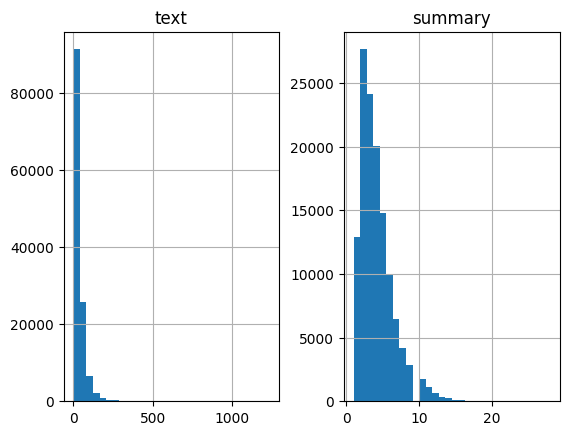

FOOD REVIEWS DATASET: 
% of summaries with len < 8 : 0.9428853941049063
% of texts with len < 50 : 0.7766895815676303
Creating final df...
Splitting data...
Tokenizing data...
X Tokenizer: 
	% of rare words in vocabulary: 65.69576132790601
	Total Coverage of rare words: 1.7851696951213896
	X_vocab =  14075
y Tokenizer: 
	% of rare words in vocabulary: 76.56593809593663
	Total Coverage of rare words: 3.778434287958601
85689 85689
	y_vocab =  3196
Cleaning training and validation data...


Setting model parameters...
Building and Compiling model... 


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 50, 100)      1407500     ['input_12[0][0]']               
                                                                                                  
 lstm_4 (LSTM)                  [(None, 50, 300),    481200      ['embedding_2[0][0]']            
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                            

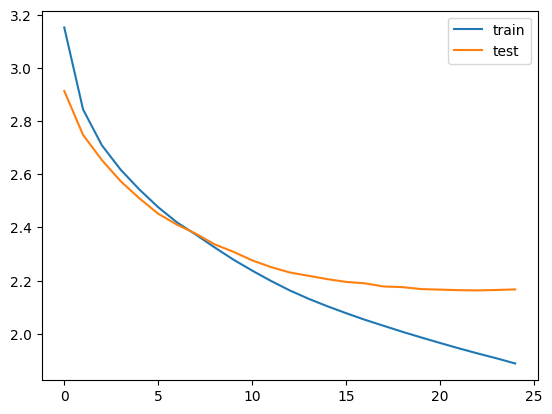

In [32]:
model_execute(True) # ~2-3 hrs with GPU | ~ 12 hrs without GPU

In [33]:
model_predict(True, len(y_val))

Predicting...
Text: cookies delicious period happen organic happen vegan kids cookies cook vegan food looking cookies banana pudding gotten around making pudding yet cookies almost gone thank goodness subscribe save 
Original summary: great tasting cookies not just for kids 
Predicted summary:  cookies


Text: present grandmother loves tea pleased get glad bought sent 
Original summary: present 
Predicted summary:  great tea


Text: bought really impressed crunchy nutty good berry flavor ten year old even liked plus felt like snacking something halfway healthy going try vanilla flavor next 
Original summary: very tasty 
Predicted summary:  good but not great


Text: looking cool gift someone special maybe special still need preserve reputation cutting edge trend setter take someone idea pasta well idea anything different find supermarket isle hey cooking shows tv top chef stuff smile complimented great taste gift giving 
Original summary: cool gift you look great giving it 
Predicted s